https://www.kaggle.com/code/krsnewwave/clv-with-lifetimes-and-featuretools/notebook

In [30]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for autograd>=1.2.0 from https://files.pythonhosted.org/packages/81/70/d5c7c2a458b8be96495c8b1634c2155beab58cbe864b7a9a5c06c2e52520/autograd-1.6.2-py3-none-any.whl.metadata
  Obtaining dependency information for dill>=0.2.6 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 9.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.5 MB/s eta 0:00:00
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=28da42e9d006ca1d62b223452798b0252957aaa8fe4ef81ccf751b6d4fe508f5
  Stored in directory: /Users/keithlowton/Library/Caches/pip

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from scipy.stats import beta
import lifetimes
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter, ModifiedBetaGeoFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_expected_repeat_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes import GammaGammaFitter
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Functions

### Read the data

In [35]:
orders = pd.read_csv('olist_orders_dataset.csv')
print(orders.shape)
print(list(orders.columns))
for name in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders[name] = pd.to_datetime(orders[name])
orders.head()

(99441, 8)
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
(99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [8]:
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
print(reviews.shape)
print(list(reviews.columns))
for name in ['review_creation_date', 'review_answer_timestamp']:
    reviews[name] = pd.to_datetime(reviews[name])
reviews.head()

(99224, 7)
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [10]:
payments = pd.read_csv('olist_order_payments_dataset.csv')
print(payments.shape)
print(list(payments.columns))
payments.head()

(103886, 5)
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [34]:
order_items = pd.read_csv('olist_order_items_dataset.csv')
print(order_items.shape)
print(list(order_items.columns))
for name in ['shipping_limit_date']:
    order_items[name] = pd.to_datetime(order_items[name])
order_items.head()

(112650, 7)
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [13]:
sellers = pd.read_csv('olist_sellers_dataset.csv')
print(sellers.shape)
print(list(sellers.columns))
sellers.head()

(3095, 4)
['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [38]:
customers = pd.read_csv('olist_customers_dataset.csv')
print(customers.shape)
print(list(customers.columns))
customers.head()

(99441, 5)
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Preprocess the data

In [36]:
costs = order_items.groupby('order_id')['price'].sum().reset_index()
costs.head()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [39]:
customers = customers[['customer_id', 'customer_unique_id']].set_index('customer_id')
customers.head()

,customer_unique_id
customer_id,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066


In [75]:
transactions = pd.merge(orders, customers, on='customer_id', how='inner')
transactions = transactions[['customer_unique_id', 'order_id','order_purchase_timestamp']]
transactions.rename(columns={"order_purchase_timestamp": "order_date"}, inplace = True)
transactions.head()

,customer_unique_id,order_id,order_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [76]:
transactions = pd.merge(costs, transactions, on='order_id', how = 'inner')
transactions.rename(columns={"customer_unique_id": "customer_id",
                             "price":"total_cost"}, inplace = True)
transactions['order_date'] = pd.to_datetime(transactions['order_date'])
transactions['order_date'] = transactions['order_date'].dt.date
transactions.head()


,order_id,total_cost,customer_id,order_date
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,871766c5855e863f6eccc05f988b23cb,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,239.90,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,199.00,3818d81c6709e39d06b2738a8d3a2474,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,12.99,af861d436cfc08b2c2ddefd0ba074622,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04


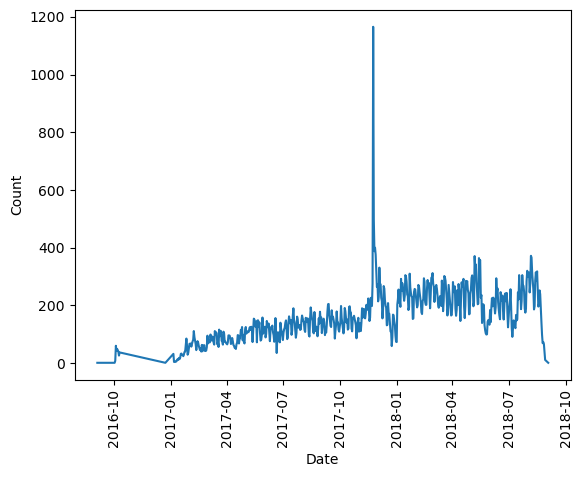

In [56]:
transactions.order_date.value_counts().plot()
plt.ylabel("Count")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.show()

### Model

The model requires RFM input data, which requires that for each customer, we have info on their most recent purchase, the frequency of their purchases and the total monetary value of their purchases.

In [60]:
vc_num_purchases_by_customer = transactions.groupby("customer_id")["order_id"].nunique().value_counts()
vc_num_purchases_by_customer = vc_num_purchases_by_customer.sort_index()
vc_num_purchases_by_customer.head()

1    92507
2     2673
3      192
4       29
5        9
Name: order_id, dtype: int64

In [65]:
oi_trans = pd.merge(order_items, transactions, on='order_id', how = 'inner')
nunique_items_per_customer = oi_trans.groupby("customer_id")["product_id"].nunique()
vc_num_items_per_customer = nunique_items_per_customer.value_counts()
vc_num_items_per_customer = vc_num_items_per_customer.sort_index()
vc_num_items_per_customer.head()

1    89964
2     4683
3      559
4      152
5       32
Name: product_id, dtype: int64

In [66]:
print("Average number of purchases: {:.2f}".format(transactions.groupby("customer_id")["order_id"].nunique().mean()))
print("Average number of items bought per customer: {:.2f}".format(
    nunique_items_per_customer.mean()))

Average number of purchases: 1.03
Average number of items bought per customer: 1.07


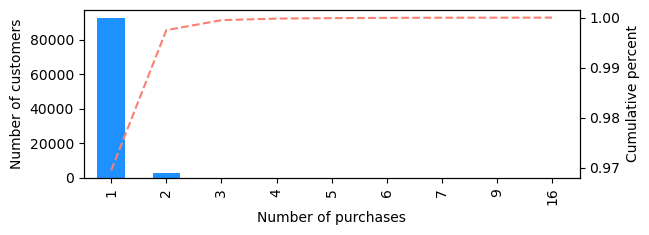

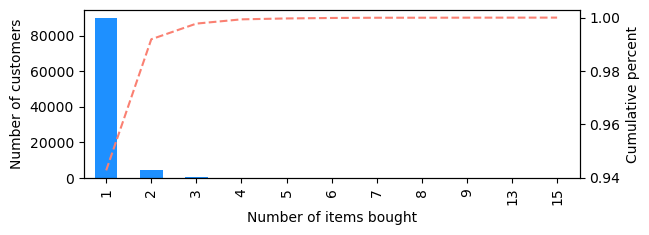

In [68]:
### plot of number of orders per customer ###

ax = plt.figure().add_subplot(211)
vc_num_purchases_by_customer.plot.bar(color='dodgerblue', ax=ax)

pct_cumsum_vc = vc_num_purchases_by_customer.cumsum() / vc_num_purchases_by_customer.sum()

ax2=ax.twinx()
ax.set_ylabel("Number of customers")
ax.set_xlabel("Number of purchases")
ax2.set_ylabel("Cumulative percent")
ax2.plot(range(len(vc_num_purchases_by_customer)), pct_cumsum_vc, linestyle='--', color='salmon')

### plot of number of items bought per customer ###

ax = plt.figure().add_subplot(212)
vc_num_items_per_customer.plot.bar(color='dodgerblue', ax=ax)

pct_cumsum_vc = vc_num_items_per_customer.cumsum() / vc_num_items_per_customer.sum()

ax2=ax.twinx()
ax.set_ylabel("Number of customers")
ax.set_xlabel("Number of items bought")
ax2.set_ylabel("Cumulative percent")
ax2.plot(range(len(vc_num_items_per_customer)), pct_cumsum_vc, linestyle='--', color='salmon')
plt.show();

In [70]:
print('Length of transaction duration: ',np.max(transactions.order_date) - np.min(transactions.order_date))

Length of transaction duration:  729 days, 0:00:00


In [102]:
transactions.head()

,order_id,total_cost,customer_id,order_date
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,871766c5855e863f6eccc05f988b23cb,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,239.90,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,199.00,3818d81c6709e39d06b2738a8d3a2474,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,12.99,af861d436cfc08b2c2ddefd0ba074622,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04


In [77]:
calibration_period_ends = '2018-06-30'

summary_cal_holdout = calibration_and_holdout_data(transactions, 
                                                   customer_id_col = 'customer_id', 
                                                   datetime_col = 'order_date', 
                                                   freq = 'D',
                                                   calibration_period_end = calibration_period_ends,
                                                   observation_period_end = '2018-09-28', 
                                                   monetary_value_col = 'total_cost' )

In [78]:
summary_cal_holdout[:2]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,51.0,0.0,0.0,0.0,90.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,54.0,0.0,0.0,0.0,90.0


### NBD Model

The Beta Geometric, Negative Binomial Distribution addresses two problems, 1) the probability of the customer being active or inactive (alive or dead in literature!), and 2) the probability of the number of purchases. (1) is modeled by the beta distribution and (2) is by a Poisson distribution. Each individual or cohort has their own parameters for both of these prediction problems. A simple way to think about it is having a coin and a die to model (1) and (2).


In [80]:
mbgf = ModifiedBetaGeoFitter()
mbgf.fit(summary_cal_holdout["frequency_cal"], 
         summary_cal_holdout["recency_cal"], 
         summary_cal_holdout["T_cal"], 
         iterative_fitting=3, verbose=True)


/Users/keithlowton/anaconda3/envs/CLTV/lib/python3.10/site-packages/lifetimes/fitters/__init__.py:101: OptimizeWarning: Unknown solver options: iterative_fitting
  output = minimize(


Optimization terminated successfully.
         Current function value: 0.078837
         Iterations: 56
         Function evaluations: 58
         Gradient evaluations: 58


<lifetimes.ModifiedBetaGeoFitter: fitted with 83128 subjects, a: 8.12, alpha: 108.46, b: 0.92, r: 0.24>


Here are visuals on gauging the performance of our model. It can be seen in both the calibration period (left) and the validation period (right) tests that the model breaks down in trying to predict 4 or more purchases because of the lack of data around this behavior.

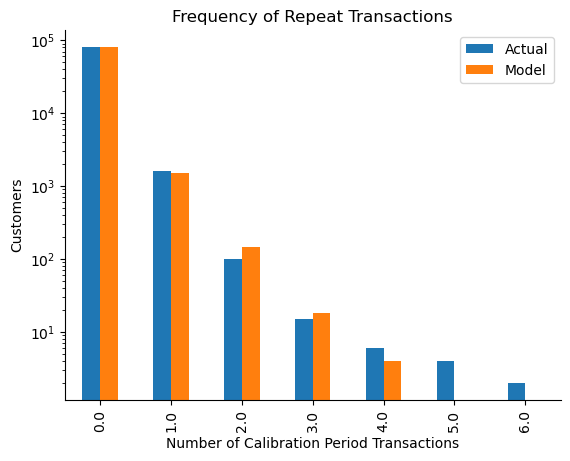

In [82]:
ax = plot_period_transactions(mbgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

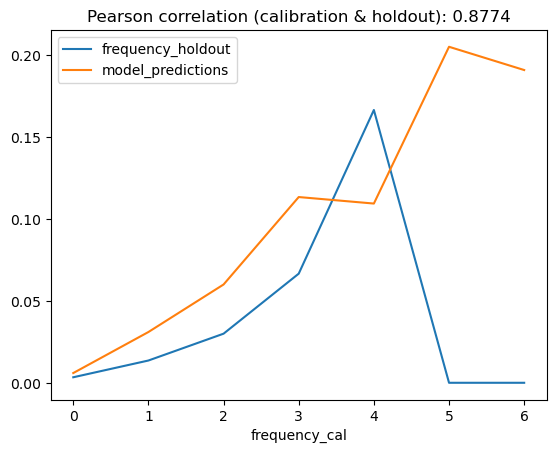

In [85]:
n = 7

summary = summary_cal_holdout.copy()
duration_holdout = summary.iloc[0]['duration_holdout']

summary['model_predictions'] = summary.apply(lambda r: mbgf.conditional_expected_number_of_purchases_up_to_time(
    duration_holdout, r['frequency_cal'], r['recency_cal'], r['T_cal']), axis=1)
agg_data = summary.groupby("frequency_cal")[['frequency_holdout', 'model_predictions']].mean()
ax = agg_data.iloc[:n].plot(title="Pearson correlation (calibration & holdout): {:.4f}".format(agg_data.corr().min().min()))
ax.set_xticks(agg_data.iloc[:n].index);

The figures below depict frequency in the x axis and recency in the y axis. Frequent and most recent buyers are at the rightmost part of the graph. In the figure (a) below, the expected number of future purchases is very low (0.6) even for the most devoted of buyers (bought recently and bought frequently) in the next 120 days. In (b), even the most devoted of buyers only have some 60% chance of being active. This is due to the very sparse buying pattern of each customer in the data.

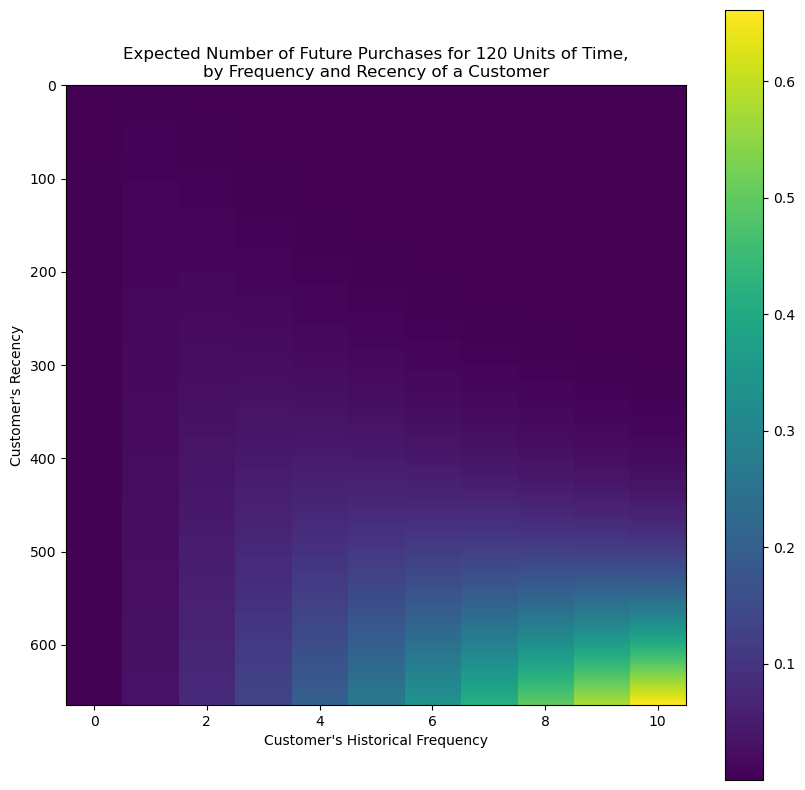

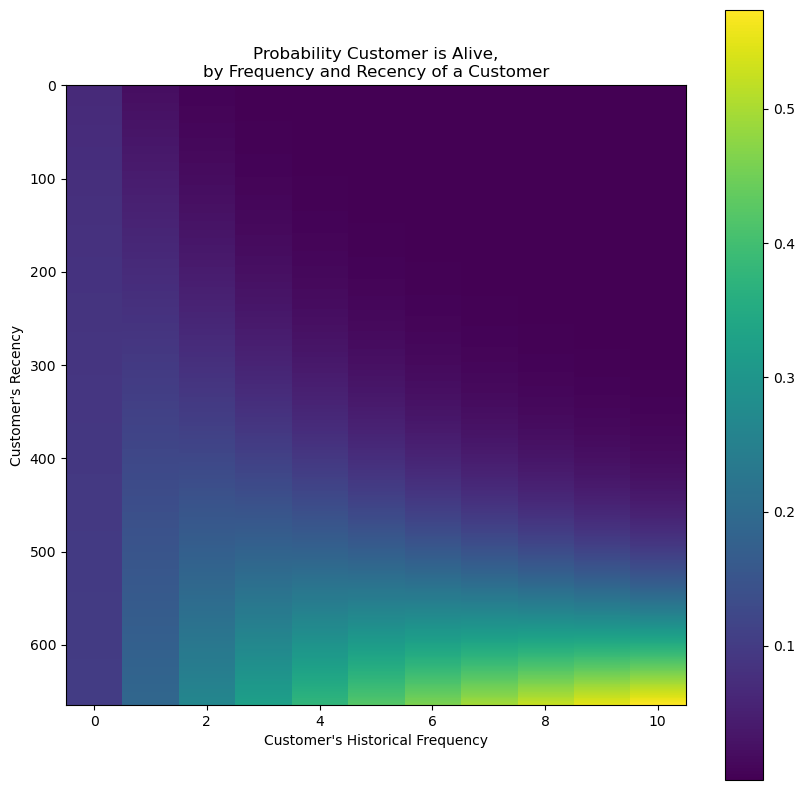

In [84]:
plt.figure(figsize=(10, 10))
plot_frequency_recency_matrix(mbgf, T=120, );

plt.figure(figsize=(10, 10))
plot_probability_alive_matrix(mbgf);

In [86]:
t = 120
predicted_purchases = mbgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                               summary_cal_holdout['frequency_cal'], 
                                                                               summary_cal_holdout['recency_cal'],
                                                                               summary_cal_holdout['T_cal'])
predicted_purchases.sort_values().tail(4)

customer_id
fe81bb32c243a86b2f86fbf053fe6140    0.323113
ca77025e7201e3b30c44b472ff346268    0.413244
6469f99c1f9dfae7733b25662e7f1782    0.426639
8d50f5eadf50201ccdcedfb9e2ac8455    0.563370
dtype: float64

With the model, one can output the ranking of the customers according to the expected number of purchases in the future. This ranking could be used to determine marketing strategies for different segments. Here is the probability of being alive after each buying pattern of the top 4 customers. These top 4 is computed from the highest expected number of purchases up to half a year.

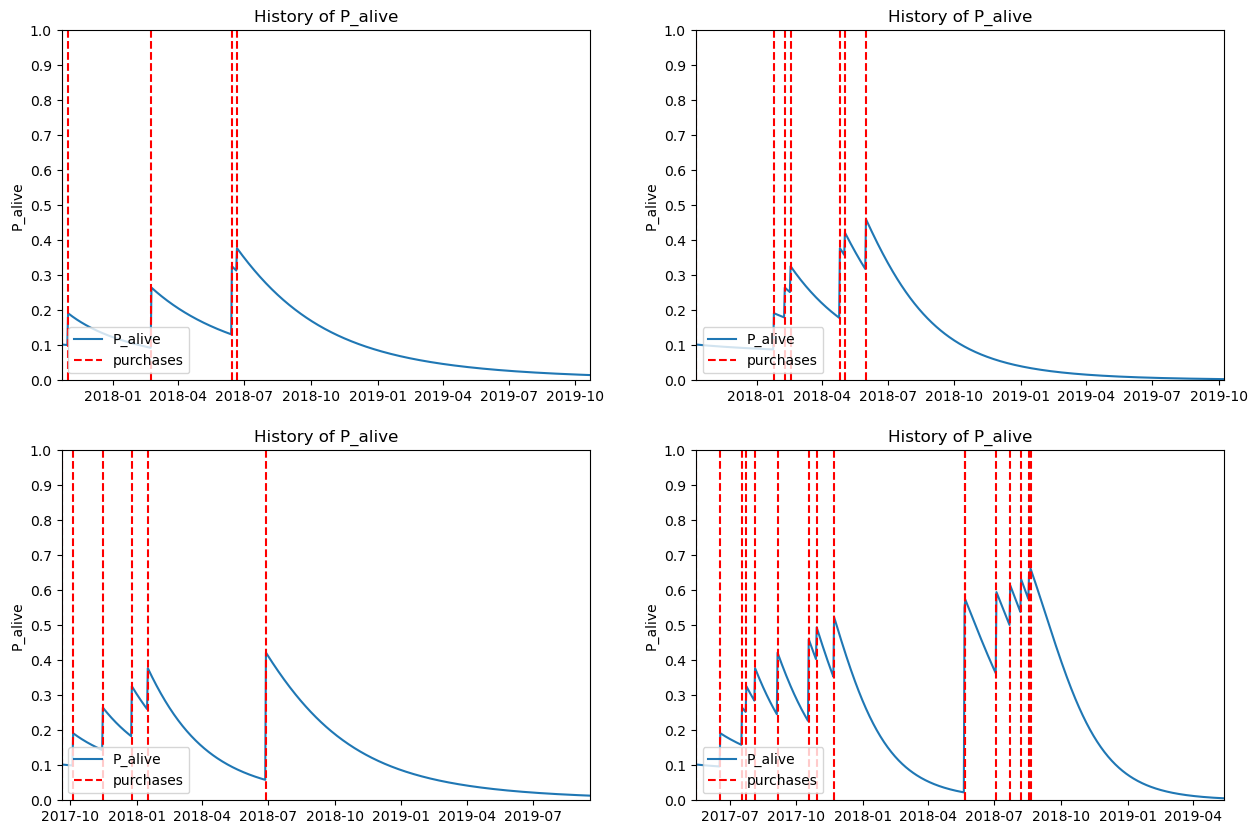

In [88]:
fig = plt.figure(figsize=(15, 10))

for idx, customer_id in enumerate(predicted_purchases.sort_values().tail(4).index, 1):
    # all days
    days_since_birth = (max(transactions.order_date - min(transactions.order_date))).days
    sp_trans = transactions.loc[transactions['customer_id'] == customer_id]
    
    plot_history_alive(mbgf, days_since_birth, sp_trans, 'order_date', ax=fig.add_subplot(2, 2, idx))

### Adding Monetary, GammaGamma Filter

                    frequency_cal  monetary_value_cal
frequency_cal            1.000000           -0.003018
monetary_value_cal      -0.003018            1.000000


/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_1567/1388184756.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(returning_customers_summary["monetary_value_cal"], ax=axes[0], )
/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_1567/1388184756.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

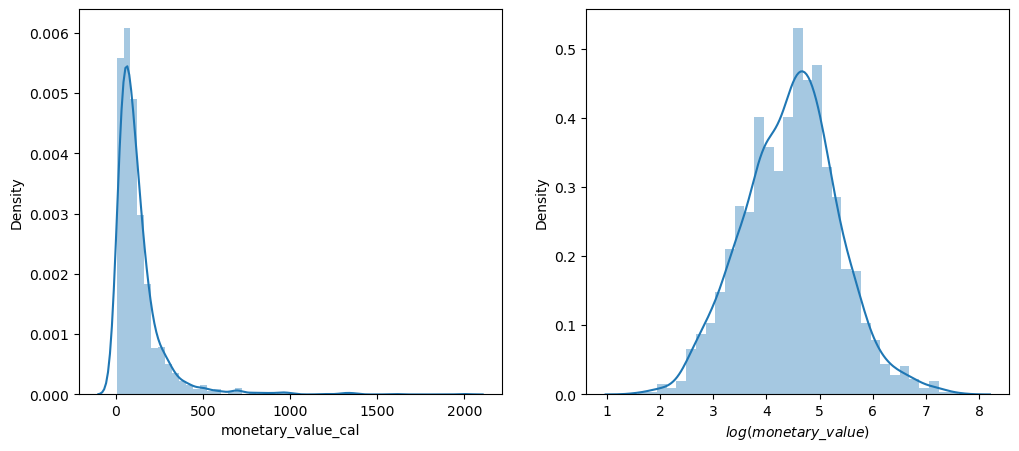

In [90]:
### weak correlation between monetary and frequency ###

returning_customers_summary = summary_cal_holdout[summary_cal_holdout["frequency_cal"] > 0]
print(returning_customers_summary[["frequency_cal", "monetary_value_cal"]].corr())

fig, axes = plt.subplots(1,2,figsize=(12, 5))
sns.distplot(returning_customers_summary["monetary_value_cal"], ax=axes[0], )
sns.distplot(np.log(returning_customers_summary["monetary_value_cal"] + 1), ax=axes[1], axlabel='$log(monetary\_value)$')
plt.show()

In [92]:
gg = GammaGammaFitter()
gg.fit(returning_customers_summary["frequency_cal"], 
       returning_customers_summary["monetary_value_cal"], verbose=True)

Optimization terminated successfully.
         Current function value: 5.761552
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29


<lifetimes.GammaGammaFitter: fitted with 1745 subjects, p: 2.70, q: 3.00, v: 96.25>

In [93]:
expected_average_profit_validation = gg.conditional_expected_average_profit(
    summary_cal_holdout['frequency_holdout'],
    summary_cal_holdout['monetary_value_holdout'])

expected_average_profit = gg.conditional_expected_average_profit(
    summary_cal_holdout['frequency_cal'], summary_cal_holdout['monetary_value_cal'])

print("With non-repeat buyers")
print("Train correlation")
print(pd.Series.corr(summary_cal_holdout["monetary_value_cal"], expected_average_profit).round(4))

print("Validation correlation")
print(pd.Series.corr(summary_cal_holdout["monetary_value_holdout"], expected_average_profit_validation).round(4))

With non-repeat buyers
Train correlation
0.7687
Validation correlation
0.6719


In [94]:
expected_average_profit_validation = gg.conditional_expected_average_profit(
    returning_customers_summary['frequency_holdout'], returning_customers_summary['monetary_value_holdout'])

expected_average_profit = gg.conditional_expected_average_profit(
    returning_customers_summary['frequency_cal'], returning_customers_summary['monetary_value_cal'])

print("Repeat buyers only")
print("Train correlation")
print(pd.Series.corr(returning_customers_summary["monetary_value_cal"], expected_average_profit).round(4))

print("Validation correlation")
print(pd.Series.corr(returning_customers_summary["monetary_value_holdout"], expected_average_profit_validation).round(4))

Repeat buyers only
Train correlation
0.9981
Validation correlation
0.3564


In [100]:
mean_absolute_error(returning_customers_summary["monetary_value_holdout"], expected_average_profit_validation)

128.01034494937343

In [101]:
print("Expected average profit validation: {:.2f}, Average profit validation: {:.2f}".format(
    gg.conditional_expected_average_profit(
        summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['monetary_value_cal']
    ).mean(),
    summary_cal_holdout[summary_cal_holdout['frequency_cal']>0]['monetary_value_cal'].mean()))

Expected average profit validation: 129.63, Average profit validation: 129.45


**Conclusions:**
* Repeat purchases could be predicted (holdout set's pearson correlation with predictions) although the probability is very low (expected number of future purchases).
* Monetary value predictions has good correlation although this includes the non-repeat buyers.
* For the repeat buyers, monetary value predictions' correlation is low. The exact monetary value is hard to predict since for an e-commerce site, the variety of items is very large.